In [1]:
from stdb import load_db 
import obspy 
import pickle
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import glob
import pygmt
from colorspacious import cspace_converter

In [28]:
def rot3D(inc, baz):
    """
    Defines rotation matrix from incidence and back-azimuth angles

    Parameters
    ----------
    inc : float
        Incidence angle in degrees
    baz : float
        Back-azimuth angle in degrees

    Returns
    -------
    M : :class:`~numpy.ndarray`
        Rotation matrix

    """

    # Angles in radians
    inc = inc/180.*np.pi
    baz = baz/180.*np.pi

    # Define rotation matrix
    M = [[np.cos(inc), -np.sin(inc)*np.sin(baz),
          -np.sin(inc)*np.cos(baz)],
         [np.sin(inc), np.cos(inc)*np.sin(baz),
          np.cos(inc)*np.cos(baz)],
         [0., -np.cos(baz), np.sin(baz)]]

    return M
def init_splitw(ax, title):
    ax.clear()
    ax.set_ylim((-1.3, 1.3))
    ax.set_title(title, fontsize=16,fontweight='bold')
    ax.set_yticks(())
    return ax

def init_pmotion(ax,title):
    ax.clear()
    ax.set_ylim((-1.2, 1.2))
    ax.set_xlim((-1.2, 1.2))
    ax.set_yticks(())
    ax.set_xticks(())
    ax.set_xlabel(r'W $\longleftrightarrow$ E')
    ax.set_ylabel(r'S $\longleftrightarrow$ N')
    ax.set_title(title, fontsize=16,fontweight='bold')
    return ax


def init_emap(ax, title):
    ax.clear()
    ax.set_title(title, fontsize=16,fontweight='bold')
    ax.set_ylabel(r'$\phi$ (°)', labelpad=-10)
    ax.set_xlabel(r'$\delta t$ (s)', labelpad=-2)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    ax.set_xlim(0,4)
    ax.set_ylim(-90,90)
    return ax

In [100]:
path = '/Volumes/home/06_NTU_thesis/Thesis_figure/Ch3/Null/20150916_140322'
# if len(glob.glob(path+'/*')) > 10 :
calc_type = 'manual'
Meta_pkl = path + '/Meta_manual.pkl'
Station_data_pkl = path + '/Station_data.pkl'
ZNE_pkl = path + '/ZNE_data.pkl'
LQT_pkl = path + '/LQT_data.pkl'
Split_result_pkl = path + '/Split_results_manual.pkl'
SC_result_pkl = path + '/SC_res_manual.pkl'
RC_result_pkl = path + '/RC_res_manual.pkl'
#     pick_pkl = path + 'Pickphase.pkl'
# else :
#     calc_type = 'auto'
#     Meta_pkl = path + 'Meta_data.pkl'
#     Station_data_pkl = path + 'Station_data.pkl'
#     ZNE_pkl = path + 'ZNE_data.pkl'
#     LQT_pkl = path + 'LQT_data.pkl'
#     Split_result_pkl = path + 'Split_results_auto.pkl'
#     SC_result_pkl = path + 'SC_res.pkl'
#     RC_result_pkl = path + 'RC_res.pkl'    
    
print(calc_type)

manual


In [101]:
Meta = pickle.load(open(Meta_pkl, "rb"))
Station_data = pickle.load(open(Station_data_pkl, "rb"))
ZNE = pickle.load(open(ZNE_pkl, "rb"))
LQT = pickle.load(open(LQT_pkl, "rb"))
Split_result = pickle.load(open(Split_result_pkl, "rb"))
SC_res = pickle.load(open(SC_result_pkl, "rb"))
RC_res = pickle.load(open(RC_result_pkl, "rb"))
# if calc_type == 'manual':
#     Pick = pickle.load(open(pick_pkl, "rb"))

In [102]:
ZNE

3 Trace(s) in Stream:
.SHEN..HHZ | 2015-09-16T14:24:19.640000Z - 2015-09-16T14:32:19.540000Z | 10.0 Hz, 4800 samples
.SHEN..HHN | 2015-09-16T14:24:19.640000Z - 2015-09-16T14:32:19.540000Z | 10.0 Hz, 4800 samples
.SHEN..HHE | 2015-09-16T14:24:19.640000Z - 2015-09-16T14:32:19.540000Z | 10.0 Hz, 4800 samples

In [119]:
try: 
    wind_start = Meta.tpicked1
    wind_end   = Meta.tpicked2
except:
    wind_start = 1503-5
    wind_end = 1503+25
t1 = Meta.time + wind_start #+ Meta.ttime 
t2 = Meta.time + wind_end #+ Meta.ttime

In [120]:
Meta.tpicked

1503.2891251496351

In [121]:
trL_ori = LQT.select(component='L')[0].copy()
trQ_ori = LQT.select(component='Q')[0].copy()
trT_ori = LQT.select(component='T')[0].copy()
# filter just for plot partical motion
ZNE.filter('bandpass',freqmin=Meta.fmin,freqmax=Meta.fmax,corners=4, zerophase=True)
trZ = ZNE.select(component='Z')[0].copy()
trN = ZNE.select(component='N')[0].copy()
trE = ZNE.select(component='E')[0].copy()

trL = trL_ori.copy()
trQ = trQ_ori.copy()
trT = trT_ori.copy()
trL.trim(t1,t2)
trQ.trim(t1,t2)
trT.trim(t1,t2)
trZ.trim(t1,t2)
trN.trim(t1,t2)
trE.trim(t1,t2)

.SHEN..HHE | 2015-09-16T14:28:20.140000Z - 2015-09-16T14:28:50.140000Z | 10.0 Hz, 301 samples

In [122]:
M = rot3D(Meta.inc, Meta.baz)
ZEN_RC = np.dot(
    np.transpose(M),
    [trL.data, RC_res.trQ_c.data, RC_res.trT_c.data])
E_RC = ZEN_RC[1, :]
N_RC = ZEN_RC[2, :]
ZEN_SC = np.dot(
    np.transpose(M),
    [trL.data, SC_res.trQ_c.data, SC_res.trT_c.data])
E_SC = ZEN_SC[1, :]
N_SC = ZEN_SC[2, :]

In [123]:
def plot_max(RES):
    sum1 = np.sum(np.abs(RES.trFast.data - RES.trSlow.data))
    sum2 = np.sum(np.abs(-RES.trFast.data - RES.trSlow.data))
    if sum1 < sum2: sig = 1.
    else: sig = -1.

    taxis = np.arange(RES.trFast.stats.npts) / \
        RES.trFast.stats.sampling_rate
    max1 = (RES.trFast.data).max()
    max2 = (RES.trSlow.data).max()
    mmax = np.amax([max1, max2])
    return sig, mmax

In [124]:
ang = 360. - Meta.baz
x1pos = -np.sin(ang*np.pi/180.)
y1pos = np.cos(ang*np.pi/180.)
x2pos = -x1pos
y2pos = -y1pos


/var/folders/sp/pnngww1n0q31w2plgbk53rc00000gn/T/ipykernel_93126/571673182.py:77: UserWarning: No contour levels were found within the data range.
  ecset = plt.contour(X, Y, E2, (errc, ), colors='k',linewidths=2)


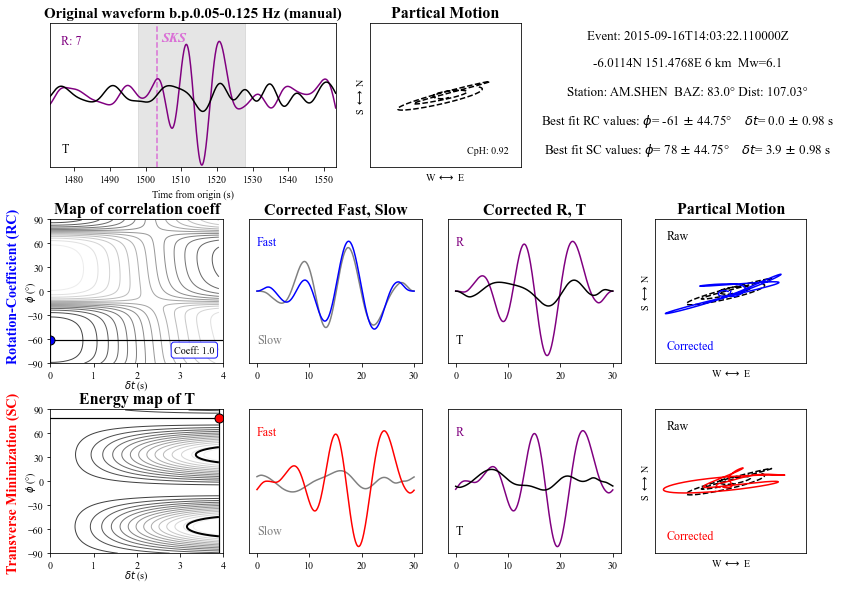

In [127]:
plt.rcParams["font.family"] = "Times New Roman"

fig = plt.figure(num=2, figsize=(12, 8), facecolor='w')
Pick = Meta.tpicked

ax0 = fig.add_axes([0.05, 0.74, 0.33, 0.25])
ax0.set_ylim((-1.2, 1.2))
ax0.set_yticks([])
ax0.set_xlabel('Time from origin (s)')
ax0.set_title(f"Original waveform b.p.{Meta.fmin}-{Meta.fmax} Hz ({calc_type})", fontsize=15, fontweight='bold')

mmax = np.amax([(trQ_ori.data).max(),(trT_ori.data).max(), (RC_res.trFast.data).max(), (SC_res.trFast.data).max()])*1.1

Null = Split_result.rsplit('/')[0]
Quality = Split_result.rsplit('/')[1]

if calc_type == 'auto':
    ax0.fill_between([Meta.ttime-wind_start,Meta.ttime+wind_end],y1=-1.2,y2=1.2,color = 'lightgrey',alpha = 0.7)
    ax0.vlines(Meta.ttime,ymin=-1.2,ymax=1.2, color = 'orchid',ls ='--')
    ax0.text(Meta.ttime+1, 0.9, f'{Meta.phase}', fontsize=12,color = 'orchid', ha='left',style='italic', weight='bold')
    ax0.text(Meta.ttime-27, 1, f'R: {round(Meta.snrq,1)}', va='top', ha='left', color='purple')
    ax0.text(Meta.ttime-27, -1, f'T: {round(Meta.snrt,1)}', va='bottom', ha='left', color='k')
    ax0.set_xlim(Meta.ttime-30,Meta.ttime+50)
    ax0.text(Meta.ttime+50,1,Null,ha='left',va='top')
    ax0.text(Meta.ttime+50,-1,Quality,ha='left',va='top')
elif calc_type == 'manual':
    ax0.fill_between([wind_start,wind_end],y1=-1.2,y2=1.2,color = 'grey',alpha = 0.2)
    ax0.vlines(Pick,ymin=-1.2,ymax=1.2, color = 'orchid',ls ='--')
    ax0.text(Pick+1, 0.9, f'{Meta.phase}', fontsize=14,color = 'orchid', ha='left',style='italic', weight='bold')
    ax0.text(Pick-27, 1, f'R: {round(Meta.threSNRQ,1)}', va='top', ha='left', color='purple',fontsize=12)
    ax0.text(Pick-27, -1, f'T', va='bottom', ha='left', color='k',fontsize=12)
    ax0.set_xlim(Pick-30,Pick+50)
#     ax0.text(Pick+48,1,Null,ha='right',va='top')
#     ax0.text(Pick+48,-1,Quality,ha='right',va='bottom')             
taxis = trQ_ori.times(reftime = Meta.time)    
ax0.plot(taxis, trQ_ori.data/mmax, 'purple')
ax0.plot(taxis, trT_ori.data/mmax, 'k')
pmmax = mmax
axp = fig.add_axes([0.42, 0.74,  0.175, 0.25])
axp = init_pmotion(ax=axp,title = 'Partical Motion')
axp.plot(trE.data/pmmax, trN.data/pmmax, 'k--')
axp.text(1,-1,f'CpH: {Meta.CpH}',ha='right',va='bottom')


axt = fig.add_axes([0.65, 0.74, 0.25, 0.25])
axt.axis('off')
# # Text box
axt.text(
    0.55, 0.7, f'Event: {Meta.time}\n\n{Meta.lat}N {Meta.lon}E {int(Meta.dep)} km  Mw={Meta.mag}', ha='center',fontsize=13)
axt.text(
    0.55, 0.5, f'Station: {Station_data.network}.{Station_data.station}  BAZ: {round(Meta.baz,2)}° Dist: {round(Meta.gac,2)}°', ha='center',fontsize=13)
axt.text(
    0.55, 0.3, f'Best fit RC values: $\phi$= {int(RC_res.phi)} $\pm$ {round(RC_res.ephi,2)}°    $\delta t $= {round(RC_res.dtt,1)} $\pm$ {round(RC_res.edtt,2)} s', ha='center',fontsize=13)
axt.text(
    0.55, 0.1, f'Best fit SC values: $\phi$= {int(SC_res.phi)} $\pm$ {round(SC_res.ephi,2)}°    $\delta t $= {round(SC_res.dtt,1)} $\pm$ {round(SC_res.edtt,2)} s', ha='center',fontsize=13)

# Energy map
axRC4 = fig.add_axes([0.05, 0.4, 0.2, 0.25])
axRC4 = init_emap(ax=axRC4, title='Map of correlation coeff')
plt.sca(axRC4)
dt = np.arange(0., Meta.maxdt, Meta.ddt)
phi = np.arange(-90., 90, Meta.dphi)
extent = [phi.min(), phi.max(), dt.min(), dt.max()]
X, Y = np.meshgrid(dt, phi)
E2 = np.roll(RC_res.Emat, int(RC_res.phi - RC_res.phi_min), axis=0)

Emin = RC_res.Emat.min()
Emax = RC_res.Emat.max()
dE = (Emax - Emin)/16.
levels = np.arange(Emin, Emax, dE)
cmap = plt.cm.RdYlBu_r
cset1 = plt.contour(X, Y, E2, levels, vmin=-1,vmax=1,linewidths=1,alpha=0.8,
                    cmap=plt.cm.get_cmap(cmap, len(levels)))
plt.gray()
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
errc = RC_res.errc
ecset = plt.contour(X, Y, E2, (errc, ), colors='k',linewidths=2)
axRC4.axvline(RC_res.dtt,color='k',lw=1.2)
axRC4.axhline(RC_res.phi,color='k',lw=1.2)
axRC4.plot(RC_res.dtt,RC_res.phi,marker='o',mec='black',mfc='b',ms=9)
bbox_prop = dict(boxstyle='round',fc='w',alpha=0.9,edgecolor='b')
axRC4.text(3.8,-80,f'Coeff: {round(errc,2)}',va='bottom',ha='right',bbox=bbox_prop)
axRC4.text(-1,-90,'Rotation-Coefficient (RC)',c='b',fontsize=14, fontweight='bold',rotation=90,va='bottom',ha='left')
# axRC4.text(3.8,-60,f'{round(RC_res.phi)}, {round(RC_res.dtt,2)}',va='bottom',ha='right',bbox=bbox_prop)


taxis = trQ.times()
# Corrected Fast, Slow window for Rotation-Correlation
axRC1 = fig.add_axes([0.28, 0.4, 0.2, 0.25])
sig, mmmax = plot_max(RC_res)
axRC1 = init_splitw(ax=axRC1, title='Corrected Fast, Slow')
axRC1.plot(taxis, sig*RC_res.trSlow.data/mmax, 'grey')
axRC1.plot(taxis, RC_res.trFast.data/mmax, 'b')
axRC1.text(taxis[0], -1, 'Slow', va='bottom',ha='left', color='grey',fontsize=12)
axRC1.text(taxis[0], 1, 'Fast', va='top', ha='left', color='b',fontsize=12)
# Corrected Q, T window
axRC2 = fig.add_axes([0.51, 0.4, 0.2, 0.25])
axRC2 = init_splitw(ax=axRC2, title='Corrected R, T')
axRC2.plot(taxis, RC_res.trQ_c.data/mmax, 'purple')
axRC2.plot(taxis, RC_res.trT_c.data/mmax, 'k')
axRC2.text(taxis[0], 1, 'R', va='top', ha='left', color='purple',fontsize=12)
axRC2.text(taxis[0], -1, 'T', va='bottom',ha='left', color='k',fontsize=12)

# Particle motion
axRC3 = fig.add_axes([0.75, 0.4, 0.175, 0.25])
axRC3 = init_pmotion(ax=axRC3,title = 'Partical Motion')
axRC3.plot(trE.data/pmmax, trN.data/pmmax, 'k--')
axRC3.plot(E_RC/pmmax, N_RC/pmmax, 'b')
axRC3.set_xlim(-1.3,1.3)
axRC3.set_ylim(-1.3,1.3)
axRC3.text(-1.1, 1.1, 'Raw', va='top', ha='left',color='k',fontsize=12)
axRC3.text(-1.1, -1.1, 'Corrected', va='bottom', ha='left', color='b',fontsize=12)




# Energy map
axSC4 = fig.add_axes([0.05, 0.07, 0.2, 0.25])
axSC4 = init_emap(ax=axSC4, title='Energy map of T')
plt.sca(axSC4)
dt = np.arange(0., Meta.maxdt, Meta.ddt)
phi = np.arange(-90., 90., Meta.dphi)
extent = [phi.min(), phi.max(), dt.min(), dt.max()]
X, Y = np.meshgrid(dt, phi)
E2 = np.roll(SC_res.Emat, int(SC_res.phi-SC_res.phi_min), axis=0)
Emin = SC_res.Emat.min()
Emax = SC_res.Emat.max()
dE = (Emax - Emin)/16.
levels = np.arange(Emin, Emax, dE)
cmap = plt.cm.RdYlBu_r
cset1 = plt.contour(X, Y, E2, levels,linewidths=1,alpha=0.8,
                    cmap=plt.cm.get_cmap(cmap, len(levels)))
plt.gray()
errc = SC_res.errc
ecset = plt.contour(X, Y, E2, (errc,), colors='k',linewidths=2)
axSC4.axvline(SC_res.dtt,color = 'k',lw=1.2)
axSC4.axhline(SC_res.phi,color = 'k',lw=1.2)
bbox_prop = dict(boxstyle='round',fc='w',alpha=0.9,edgecolor='r')
axSC4.plot(SC_res.dtt,SC_res.phi,marker='o',mec='k',mfc='r',ms=9)
axSC4.text(-1,-115,'Transverse Minimization (SC)',c='r',fontsize=14, fontweight='bold',rotation=90,va='bottom',ha='left')
# axSC4.text(3.8,-60,f'{round(SC_res.phi)}, {round(SC_res.dtt,2)}',va='bottom',ha='right',bbox=bbox_prop)


# Corrected Fast, Slow window for Silver-Chan
axSC2 = fig.add_axes([0.28, 0.07, 0.2, 0.25])
axSC2 = init_splitw(ax=axSC2, title='')
sig, mmmax = plot_max(SC_res)
axSC2.plot(taxis, sig*SC_res.trSlow.data/mmax, 'grey')
axSC2.plot(taxis, SC_res.trFast.data/mmax, 'r')
axSC2.text(taxis[0], 1, 'Fast', va='top', ha='left', color='r', fontsize=12)
axSC2.text(taxis[0], -1, 'Slow', va='bottom',ha='left', color='grey',fontsize=12)
# Corrected Q, T window
axSC1 = fig.add_axes([0.51, 0.07, 0.2, 0.25])
axSC1 = init_splitw(ax=axSC1, title='')
axSC1.plot(taxis, SC_res.trQ_c.data/mmax, 'purple')
axSC1.plot(taxis, SC_res.trT_c.data/mmax, 'k')
axSC1.text(taxis[0], 1, 'R', va='top', ha='left', color='purple',fontsize=12)
axSC1.text(taxis[0], -1, 'T', va='bottom',ha='left', color='k',fontsize=12)
# Particle motion
axSC3 = fig.add_axes([0.75, 0.07, 0.175, 0.25])
axSC3 = init_pmotion(ax=axSC3,title = '')
axSC3.plot(trE.data/pmmax, trN.data/pmmax, 'k--')
axSC3.plot(E_SC/pmmax, N_SC/pmmax, 'r')
axSC3.set_xlim(-1.3,1.3)
axSC3.set_ylim(-1.3,1.3)
axSC3.text(-1.1, 1.1, 'Raw', va='top', ha='left', color='k',fontsize=12)
axSC3.text(-1.1, -1.1, 'Corrected', va='bottom', ha='left', color='r',fontsize=12)

plt.savefig(f'{path}/Plot_diagnostic_manual_v2.pdf', bbox_inches='tight')
plt.savefig(f'{path}/Plot_diagnostic_manual_v2.png', dpi=150,bbox_inches='tight')

/var/folders/sp/pnngww1n0q31w2plgbk53rc00000gn/T/ipykernel_93126/3135741986.py:5: SyntaxWarning: Short-form parameter (C) is not recommended. Use long-form parameter 'lakes' instead.
  fig.coast(region='g',
coast [WARNING]: Fill/clip continent option (-G) may not work for this projection.
coast [WARNING]: If the antipode (0/1) is in the ocean then chances are good it will work.
coast [WARNING]: Otherwise, avoid projection center coordinates that are exact multiples of 224.19 degrees.
/Users/tong/opt/anaconda3/envs/split/lib/python3.9/site-packages/pygmt/helpers/decorators.py:873: SyntaxWarning: Short-form parameter (t) is not recommended. Use long-form parameter 'transparency' instead.
  return module_func(*args, **kwargs)
/Users/tong/opt/anaconda3/envs/split/lib/python3.9/site-packages/pygmt/helpers/decorators.py:873: SyntaxWarning: Short-form parameter (t) is not recommended. Use long-form parameter 'transparency' instead.
  return module_func(*args, **kwargs)
/Users/tong/opt/anacond

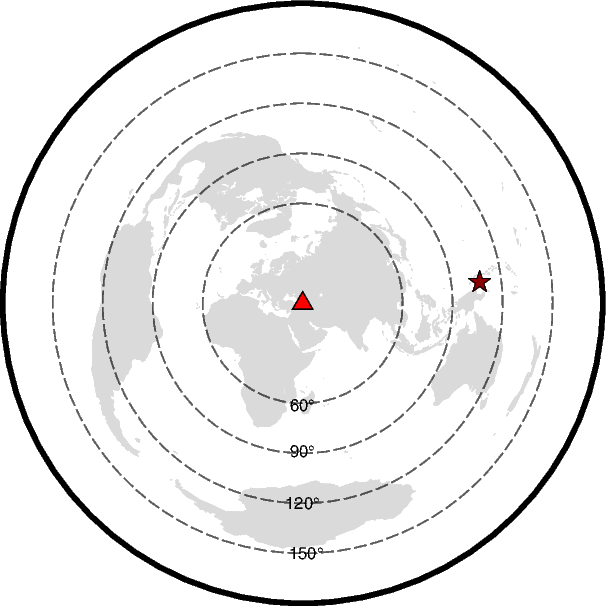

In [126]:
fig = pygmt.Figure()
lat = Station_data.latitude
lon = Station_data.longitude
colfill = '217.6/217.6/217.6'
fig.coast(region='g', 
          projection = 'E' + str(lon) + '/'+ str(lat) + '/180/2i', 
          resolution = 'c', 
          land = colfill, 
          shorelines ='1/0.1p,' + colfill, 
          C = colfill, 
          frame = True)
fig.plot(x = lon, y = lat, style ='t0.2c', pen ='0.2', color = 'red')

distlims = [60,90,120,150]
for dists in distlims:
    fig.plot(x = lon, 
             y = lat, 
             style ='E-' + str(2 * dists) + 'd', 
             pen ='0.3p,black,3_1:0p',
             t = '60')
fig.text(x = 44, y = -20,  text = f'60@.', font='4p')
fig.text(x = 44, y = -48,  text = '90@.', font='4p')
fig.text(x = 44, y = -79,  text = '120@.', font='4p')
fig.text(x = -137, y = -71,   text = '150@.', font='4p')
fig.plot(x = Meta.lon, y= Meta.lat, style ='a0.2c', pen ='0.1', color = 'darkred')
fig.show()
fig.savefig(f'{path}/dist_v2.pdf', dpi = 300)
fig.savefig(f'{path}/dist_v2.png', dpi = 300)